In [577]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import re
import warnings
warnings.filterwarnings('ignore')

import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

In [578]:
dfc = pd.read_csv("accountability_console_data_cleaned.csv")
dfb = pd.read_csv("benchmark_data_cleaned.csv")

# Cleaning

In [579]:
#drop 'ELIGIBLE' NANs
dfc.dropna(axis=0, subset=['ELIGIBLE'], inplace=True)

In [580]:
dfc.head()

,Complaint_Name,Project,Country_1,Country_2,Country_3,Country_4,IAM,Bank,External_ID,Status,...,Compliance_Review_Start,Compliance_Review_End,Compliance_Review_Status,If_No_Compliance_Report_Why,Monitoring_Start,Monitoring_End,Monitoring_Status,If_No_Monitoring_Why,Date_Closed,ELIGIBLE
0,4 MW Hydro Power Project Thack Chilas,4 MW Hydro Power Project Thack Chilas,Pakistan,NaN,NaN,NaN,ABD_SPF_CRP,Asian Development Bank,no_id_25_24,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,2013-08-31,0.0
2,ABCI Investments,ABCI Investments,Netherlands,NaN,NaN,NaN,IFC_CAO,IFC/MIGA,no_id_21_28,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,2007-01-31,0.0
3,AccessBank,AccessBank,Azerbaijan,NaN,NaN,NaN,IFC_CAO,IFC/MIGA,no_id_21_72,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,2013-02-28,0.0
4,ACME Energy-01,ACME Energy-01,India,NaN,NaN,NaN,IFC_CAO,IFC/MIGA,no_id_21_80,Closed Without Results,...,NaN,NaN,not_undertaken,Case closed in earlier stage,NaN,NaN,not_undertaken,Case closed in earlier stage,2013-07-31,0.0
5,Aconcagua-01/Santa Barbara,Aconcagua-01/Santa Barbara,Chile,NaN,NaN,NaN,IFC_CAO,IFC/MIGA,153,Closed Without Results,...,NaN,NaN,not_undertaken,Mechanism deemed involvement unnecessary,NaN,NaN,not_undertaken,Case closed in earlier stage,2010-06-30,1.0


In [581]:
dfc.IAM.value_counts()

IFC_CAO        226
ABD_SPF_CRP    107
WB_Panel        95
IDB_MICI        91
EIB_CM          81
ERBD_PCM        81
AfDB_IRM        18
ERBD_IRM        13
OPIC_OA         11
COES_CSR         6
JICA_EEG         4
FMO_ICM          4
JBIC_EEG         2
Name: IAM, dtype: int64

In [582]:
dfc.Bank.value_counts()

IFC/MIGA                                            226
Asian Development Bank                              107
World Bank                                           95
European Bank for Reconstruction and Development     94
Inter-American Development Bank                      91
European Investment Bank                             81
African Development Bank                             18
Overseas Private Investment Corporation              11
Canadian Office of the Extractive Sector              6
Japan International Cooperation Agency                4
Netherlands Development Finance Company               4
Japan Bank for International Cooperation              2
Name: Bank, dtype: int64

In [584]:
dfc['If_No_Eligibility_Why_1'].value_counts()

Unknown                                     207
Outside of mandate                           71
Good faith requirement not met               25
Addressed outside process                    14
Filer Issue                                  11
Forwarded to other body within bank           8
Issues previously raised                      7
Funding and/or consideration ended            6
Other                                         3
Inadequate information                        2
Mechanism deemed involvement unnecessary      2
Case closed in earlier stage                  2
Complaint withdrawn                           2
Project Completion Report issued              2
Name: If_No_Eligibility_Why_1, dtype: int64

# Eligibility by Country

In [585]:
gg = dfc.groupby('Country_1')['ELIGIBLE'].count()

In [587]:
data = [ dict(
        type = 'choropleth',
        locations = gg.index,
        locationmode = 'country names',
        z = gg.values,
        #text = gg.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.20,"rgb(40, 60, 190)"],[0.40,"rgb(70, 100, 245)"],\
            [0.55,"rgb(90, 120, 245)"],[0.75,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(280,10,30)',  # color of country borders
                width = 0.5                # width of country borders
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Complaint Count'),
      ) ]

layout = dict(
    title = 'Number of complaints since 1994, per Country',
    geo = dict(
        showframe = True,                 # frame of full map
        showcoastlines = True,            # coastline of full map
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='Number of eligible complaints by country')

In [588]:
# drop countries that have less than 6 complaints
x = dfc.Country_1.value_counts()
comp_count = pd.DataFrame(data=x).reset_index()
comp_count.columns=['country','total_complaints']
comp_count = comp_count[comp_count['total_complaints']>5]
cv = comp_count.country.values

above_5_comp = dfc[dfc['Country_1'].isin(cv)]

In [589]:
# calculate percentage of eligible complaints
elig_1 = above_5_comp.groupby('Country_1')['ELIGIBLE'].sum()
elig_1and0 = above_5_comp.groupby('Country_1')['ELIGIBLE'].count()
gg_prct = elig_1 / elig_1and0

In [590]:
data = [ dict(
        type = 'choropleth',
        locations = gg_prct.index,
        locationmode = 'country names',
        z = gg_prct.values,
        #text = gg.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.20,"rgb(40, 60, 190)"],[0.40,"rgb(70, 100, 245)"],\
            [0.55,"rgb(90, 120, 245)"],[0.75,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(280,10,30)',  # color of country borders
                width = 0.5                # width of country borders
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Eligible %'),
      ) ]

layout = dict(
    title = 'Percentage of Eligible complaints since 1994, per Country',
    geo = dict(
        showframe = True,                 # frame of full map
        showcoastlines = True,            # coastline of full map
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='Percentage of eligible complaints by country')

# Eligibility by IAM

In [591]:
# drop IAMs that have less than 20 complaints
diam = dfc.copy()
diam = diam[(dfc.IAM!='COES_CSR') & (dfc.IAM!='JICA_EEG') & (dfc.IAM!='FMO_ICM') & (dfc.IAM!='UNDP_SRM') & 
            (dfc.IAM!='JBIC_EEG') & (dfc.IAM!='AfDB_IRM') & (dfc.IAM!='ERBD_IRM') & (dfc.IAM!='OPIC_OA')]

In [592]:
diam.IAM.value_counts()

IFC_CAO        226
ABD_SPF_CRP    107
WB_Panel        95
IDB_MICI        91
EIB_CM          81
ERBD_PCM        81
Name: IAM, dtype: int64

In [593]:
iam_prct = diam.groupby('IAM')['ELIGIBLE'].sum() / diam.groupby('IAM')['ELIGIBLE'].count()
iam_prct

IAM
ABD_SPF_CRP    0.158879
EIB_CM         0.765432
ERBD_PCM       0.222222
IDB_MICI       0.164835
IFC_CAO        0.535398
WB_Panel       0.631579
Name: ELIGIBLE, dtype: float64

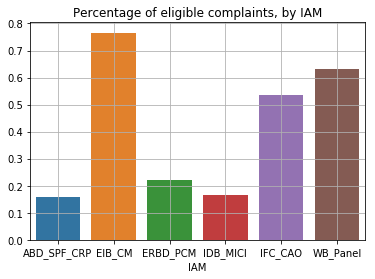

In [596]:
sns.barplot(iam_prct.index, iam_prct.values)
plt.grid()
plt.title("Percentage of eligible complaints, by IAM")
plt.show()

# Probability of complaint becoming eligible, based on number of issues

In [597]:
dfc = pd.read_csv("accountability_console_data_cleaned.csv")

#drop 'ELIGIBLE' NANs
dfc.dropna(axis=0, subset=['ELIGIBLE'], inplace=True)

In [598]:
dfc['num_issues']=0

dfc[['Issues_1','Issues_2','Issues_3','Issues_4','Issues_5','Issues_6','Issues_7',
     'Issues_8','Issues_9','Issues_10']] = dfc[['Issues_1','Issues_2','Issues_3','Issues_4','Issues_5',
                                                'Issues_6','Issues_7','Issues_8','Issues_9','Issues_10']].notnull()

dfc.Issues_1 = dfc.Issues_1.apply(lambda x: 1 if x is True else 0)
dfc.Issues_2 = dfc.Issues_2.apply(lambda x: 1 if x is True else 0)
dfc.Issues_3 = dfc.Issues_3.apply(lambda x: 1 if x is True else 0)
dfc.Issues_4 = dfc.Issues_4.apply(lambda x: 1 if x is True else 0)
dfc.Issues_5 = dfc.Issues_5.apply(lambda x: 1 if x is True else 0)
dfc.Issues_6 = dfc.Issues_6.apply(lambda x: 1 if x is True else 0)
dfc.Issues_7 = dfc.Issues_7.apply(lambda x: 1 if x is True else 0)
dfc.Issues_8 = dfc.Issues_8.apply(lambda x: 1 if x is True else 0)
dfc.Issues_9 = dfc.Issues_9.apply(lambda x: 1 if x is True else 0)
dfc.Issues_10 = dfc.Issues_10.apply(lambda x: 1 if x is True else 0)

In [599]:
dfc.num_issues = dfc.Issues_1+dfc.Issues_2+dfc.Issues_3+dfc.Issues_4+dfc.Issues_5+dfc.Issues_6+dfc.Issues_7+dfc.Issues_8+dfc.Issues_9+dfc.Issues_10

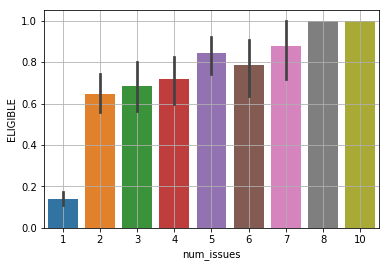

In [601]:
sns.barplot(dfc.num_issues,dfc.ELIGIBLE)
plt.grid()
plt.show()

In [604]:
print(round(dfc.num_issues.corr(dfc.ELIGIBLE),3))
print("There appears to be a correlation between number of issues per complaint and it becoming eligible.")

0.539
There appears to be a correlation between number of issues per complaint and it becoming eligible


**Modeling the probability**

In [552]:
count_issues = np.array(dfc.num_issues)   # Number of Issues
eligible = np.array(dfc.ELIGIBLE)         # Eligible or not

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.01, testval=0) # when τ=0.01, the variance is 1/τ, which is 100 
    alpha = pm.Normal("alpha", mu=0, tau=0.01, testval=0)
    p = pm.Deterministic("p", pm.math.sigmoid((-1)*beta*count_issues + alpha*(-1))) 

In [553]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=eligible)
    trace = pm.sample(3000, tune=1000, njobs=1)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 281.12it/s]


In [554]:
pm.summary(burned_trace, varnames=['alpha','beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.085125,0.156798,0.004157,1.78926,2.398382,1213.828052,1.000101
beta,-0.790753,0.063980,0.001812,-0.90994,-0.660700,1222.910304,1.001406


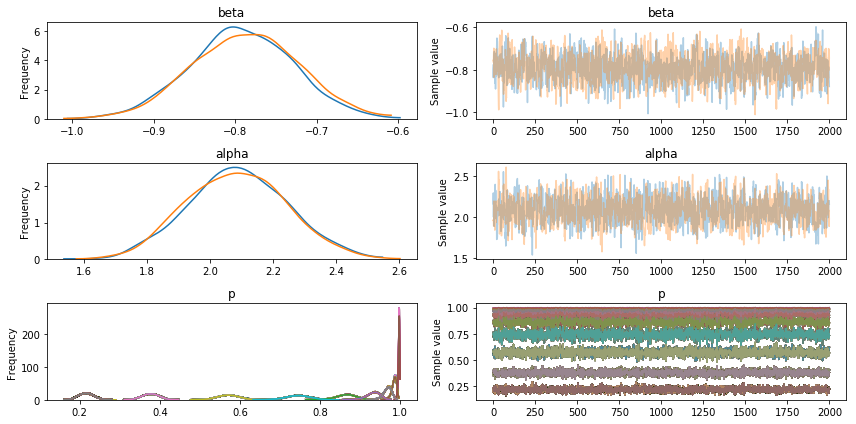

In [555]:
pm.traceplot(burned_trace)
plt.show()

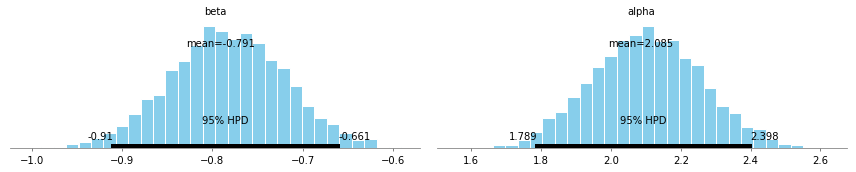

In [556]:
pm.plot_posterior(burned_trace,
                  varnames=['beta','alpha'], 
                  color='#87ceeb')
plt.show()

In [610]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(0, 10, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

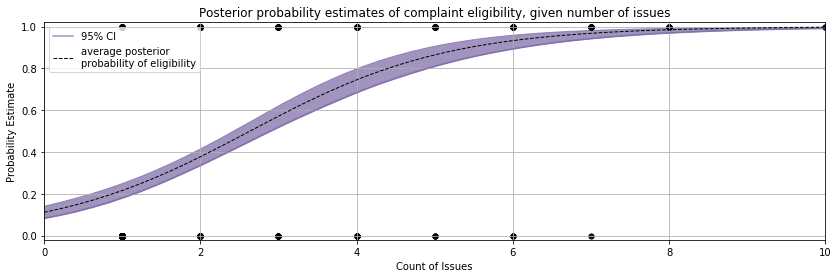

In [611]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(14, 4))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of eligibility")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper left")
plt.scatter(count_issues, eligible, color="k", s=25, alpha=0.5)
plt.xlabel("Count of Issues")

plt.ylabel("Probability Estimate")
plt.title("Posterior probability estimates of complaint eligibility, given number of issues")
plt.grid()
plt.show()

From above, we see that there is more than a 50% chance that a complaint would become eligible if it has 3 issues or more

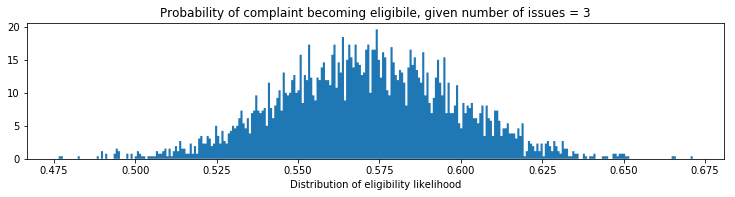

In [623]:
plt.figure(figsize=(12.5, 2.5))

prob_3 = logistic(3, beta_samples, alpha_samples)

plt.hist(prob_3, bins=300, normed=True, histtype='stepfilled')
plt.title("Probability of complaint becoming eligibile, given number of issues = 3")
plt.xlabel("Distribution of eligibility likelihood");